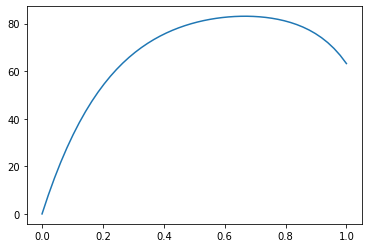

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def fun(x):
  return 100*(1-np.exp(-4*x+3*x**3))

class BiddingEvironment():
  def __init__(self,bids,sigma):
    self.bids = bids
    self.means = fun(bids)
    self.sigmas = sigma*np.ones(len(bids))

  def round(self, pulled_arm):    # pulled arm is the index of one of the bids
    return np.random.normal(self.means[pulled_arm], self.sigmas[pulled_arm])


class Learner:
  def __init__(self, n_arms):
      self.n_arms = n_arms

      # current round value
      self.t = 0 

      # list of lists to store the collected 
      # rewards for each round and for each arm
      # length of the external list: n_arms
      # length of internal list: num of times
      # we pulled a given arm
      self.rewards_per_arm = [[] for i in range(n_arms)]

      # value of the rewards for each round
      self.collected_rewards = np.array([])

  def update_observations(self, pulled_arm, reward):
      """
      update the collected_rewards and 
      rewards_per_arm

      param pulled_arm: arm pulled in this round
      param reward: reward given by environment
      """

      self.rewards_per_arm[pulled_arm].append(reward)
      self.collected_rewards = np.append(self.collected_rewards, reward)

class GTS_learner(Learner): # NON è quello che useremo noi! è gaussiano ma non tiene conto della correlazione tra braccia
  def __init__(self, n_arms):
    super().__init__(n_arms)
    self.means = np.zeros(n_arms)
    self.sigmas = np.ones(n_arms)*1000
  
  def pull_arm(self):
    return np.argmax(np.random.normal(self.means,self.sigmas))

  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward)
    self.means[pulled_arm] = np.mean(self.rewards_per_arm[pulled_arm]) # update mean of the pulled arm
    n_samples = len(self.rewards_per_arm[pulled_arm])
    if (n_samples>1):
      self.sigmas[pulled_arm] = np.std(self.rewards_per_arm[pulled_arm])/n_samples # update variance of the pulled arm

x = np.linspace(0, 1.0, 50)
y = fun(x)

plt.plot(x,y)

In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

class GPTS_learner(Learner):
  def __init__(self, n_arms, arms):
    super().__init__(n_arms)
    self.arms = arms
    self.means = np.zeros(n_arms)
    self.sigmas = np.ones(n_arms)*10
    self.pulled_arms = []
    alpha = 10.0
    kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
    self.gp = GaussianProcessRegressor(kernel = kernel, alpha = alpha**2, normalize_y = True, n_restarts_optimizer = 9)

  def UpdateObservation(self, idx, reward):
    self.update_observations(idx, reward)
    self.pulled_arms.append(self.arms[idx])

  def update_model(self):
    x = np.atleast_2d(self.pulled_arms).T
    y = self.collected_rewards
    self.gp.fit(x,y)
    self.means, self.sigmas = self.gp.predict(np.atleast_2d(self.arms).T, return_std = True)
    self.sigmas = np.maximum(self.sigmas, 1e-2)

  def update(self, pulled_arm, reward):
    self.t += 1
    self.UpdateObservation(pulled_arm, reward)
    self.update_model()
    
  def pull_arm(self):
    return np.argmax(np.random.normal(self.means,self.sigmas))

Differenza tra TS e GPTS (fatto dal prof)

In [18]:
import matplotlib.pyplot as plt

n_arms = 20
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_arms)
sigma = 10

T = 40
n_experiments = 10

gts_reward_per_experiment = []
gpts_reward_per_experiment = []

for e in range(n_experiments):
  env = BiddingEvironment(bids, sigma)
  gts_learner = GTS_learner(n_arms)
  gpts_learner = GPTS_learner(n_arms=n_arms, arms=bids) # qui metto anche bid perchè per implementare GP serve sapere le distanze tra i dati

  for t in range(T):
    pulled_arm = gts_learner.pull_arm()
    reward = env.round(pulled_arm)
    gts_learner.update(pulled_arm, reward)

    pulled_arm = gpts_learner.pull_arm()
    reward = env.round(pulled_arm)
    gpts_learner.update(pulled_arm, reward)

  gts_reward_per_experiment.append(gts_learner.collected_rewards)
  gpts_reward_per_experiment.append(gpts_learner.collected_rewards)



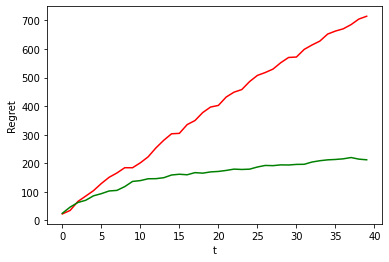

In [19]:
opt = np.max(env.means)
plt.figure(0)
plt.ylabel('Regret')
plt.xlabel('t')
plt.plot(np.cumsum(np.mean(opt - gts_reward_per_experiment, axis = 0)),'r')
plt.plot(np.cumsum(np.mean(opt - gpts_reward_per_experiment, axis = 0)),'g')

plt.show()


Implementare versione modificata di GPTS secondo le dispostzioni del punto 5

In [20]:
from scipy.stats import norm


class GPTS_learner_positive(Learner):
  def __init__(self, n_arms, arms, threshold):
    super().__init__(n_arms)
    self.arms = arms
    self.means = np.zeros(n_arms)
    self.sigmas = np.ones(n_arms)*10
    self.pulled_arms = []         # per avere il numero del round utilizzeremo len(pulled_arm)
    self.threshold = threshold
    alpha = 10.0
    kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
    self.gp = GaussianProcessRegressor(kernel = kernel, alpha = alpha**2, normalize_y = True, n_restarts_optimizer = 9)


  def UpdateObservation(self, idx, reward):
    self.update_observations(idx, reward)
    self.pulled_arms.append(self.arms[idx])

  def update_model(self):
    x = np.atleast_2d(self.pulled_arms).T
    y = self.collected_rewards
    self.gp.fit(x,y)
    self.means, self.sigmas = self.gp.predict(np.atleast_2d(self.arms).T, return_std = True)
    self.sigmas = np.maximum(self.sigmas, 1e-2)

  def update(self, pulled_arm, reward):
    self.t += 1
    self.UpdateObservation(pulled_arm, reward)
    self.update_model()

  def is_eligible(self, idx):
    proba = norm(loc = self.means[idx], scale = self.sigmas[idx]).cdf(0.0)
    if (proba < self.threshold):
      return True
    return False

    
  def pull_arm(self):
    if (len(self.pulled_arms) < 10):
      return np.random.choice(self.n_arms)   # scelta uniforme nei primi 10 round   
    sample = np.random.normal(self.means,self.sigmas)
    for i in range(len(sample)):  # controllo uno alla volta gli elementi del sample
      idx = np.argmax(np.random.normal(self.means,self.sigmas))
      if self.is_eligible(idx):
        return idx
      else:
        sample[idx] = -10000.0    # siamo sicuri che nella prossima iterazione non si sceglieà questo braccio 
    print('errore, nessun braccio eligible, ne restituisco uno a caso')    
    return np.argmax(np.random.normal(self.means,self.sigmas))

Testare il nuovo learner sull'ambiente del prof, con le disposizioni del punto 5


[11.20461938 22.44838274 35.52114792 48.50603686 59.78017612 68.38370059
 74.14405603 77.53006914 79.32150035 80.24882027 80.75296222 80.94185985
 80.71988823 79.9897205  78.8088397  77.42614406 76.19746151 75.44049629
 75.31037142 75.75341788]
[16.1911085  23.24863549 32.08407965 41.74003585 51.24489375 59.7899602
 66.86045725 72.28682199 76.2050898  78.94163809 80.8599505  82.2180167
 83.08064547 83.31243435 82.65034609 80.82871432 77.71286909 73.3959676
 68.22719124 62.76297475]
[24.60969208 27.8514505  34.45521033 43.50964746 53.68492904 63.5254602
 71.78084229 77.68991913 81.13776997 82.62788474 83.05671012 83.34493922
 84.05004317 85.11940726 85.90762483 85.47337637 83.03699511 78.39253136
 72.08243565 65.25618604]
[-3.5083375  10.29109353 27.60822705 44.66199531 58.28008036 66.8836826
 70.75967499 71.5940923  71.57463509 72.4891769  75.14114371 79.20018517
 83.44924942 86.3176119  86.54620474 83.76809773 78.75036425 73.1350878
 68.75687743 66.86774729]
[ 5.22125509 13.46568846 2

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


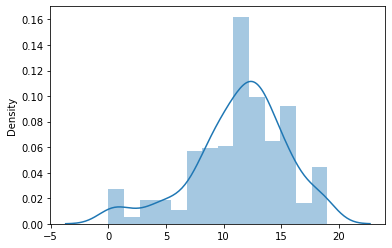

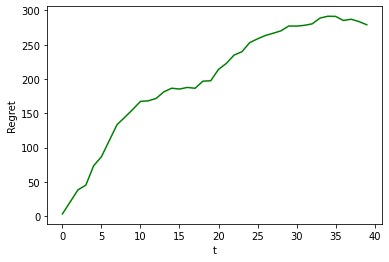

In [21]:
# da riaggiornare ogni volta

n_arms = 20
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_arms)
sigma = 10

T = 40
n_experiments = 10

gts_reward_per_experiment = []
gpts_reward_per_experiment = []

history = []

for e in range(n_experiments):
  env = BiddingEvironment(bids, sigma)
  gpts_learner = GPTS_learner_positive(n_arms=n_arms, arms=bids, threshold=0.2) # qui metto anche bid perchè per implementare GP serve sapere le distanze tra i dati

  for t in range(T):

    pulled_arm = gpts_learner.pull_arm()
    reward = env.round(pulled_arm)
    gpts_learner.update(pulled_arm, reward)
    history.append(pulled_arm)


  gpts_reward_per_experiment.append(gpts_learner.collected_rewards)
  print(gpts_learner.means)

import seaborn as sns
sns.distplot(np.array(history))

opt = np.max(env.means)
plt.figure(0)
plt.ylabel('Regret')
plt.xlabel('t')
plt.plot(np.cumsum(np.mean(opt - gpts_reward_per_experiment, axis = 0)),'g')

plt.show()

plot del grafico delle braccia tirate nel corso degli esperimenti